In [44]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
%config IPCompleter.greedy=True
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LassoCV, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import scipy
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (12, 6)})
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("../files/howpop_train.csv")
test_df = pd.read_csv("../files/howpop_test.csv")

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


<AxesSubplot:>

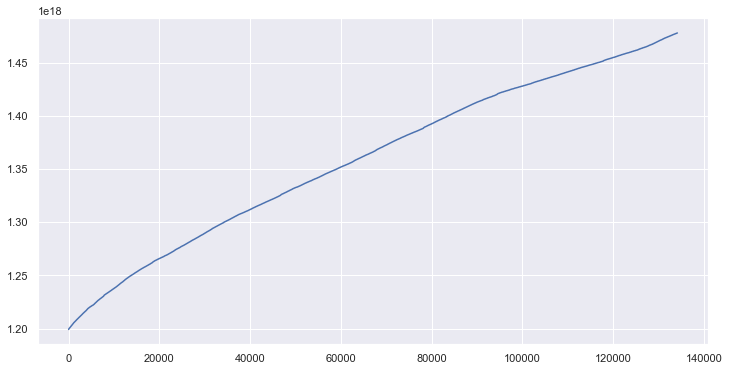

In [4]:
train_df["published"].apply(lambda ts: pd.to_datetime(ts).value).plot()

<AxesSubplot:>

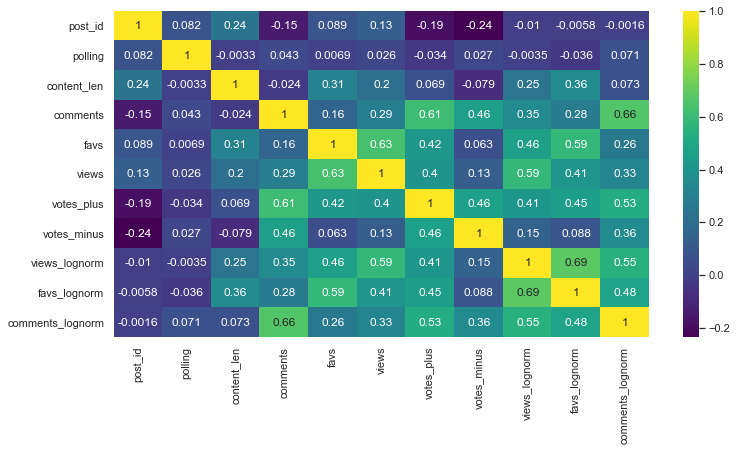

In [5]:
sns.heatmap(train_df.corr(), cmap="viridis", annot=True)

<AxesSubplot:xlabel='published', ylabel='count'>

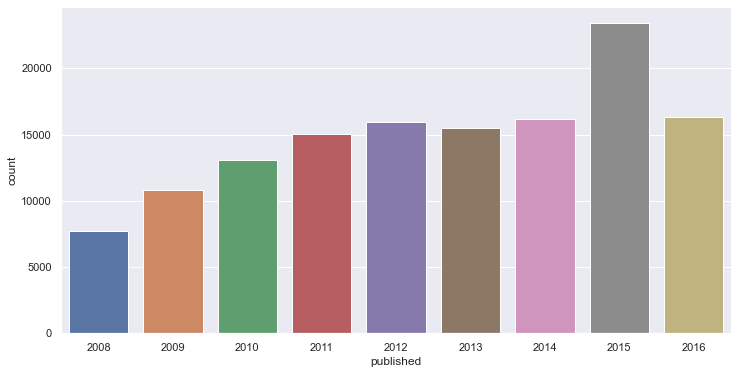

In [6]:
sns.countplot(train_df["published"].apply(lambda ts: pd.to_datetime(ts).year))

In [7]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])
len(train_df), train_size

(134137, 93895)

In [8]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [9]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [10]:
X_train.shape, X_valid.shape, X_test.shape, 

((93895, 4), (40242, 4), (3990, 4))

In [11]:
X_train.head()

,author,flow,domain,title
0,@Tapac,develop,habrahabr.ru,Новогодний подарок блоггерам — WordPress 2.3.2
1,@DezmASter,design,habrahabr.ru,"Сумасшедшие яйца, или сервис для отслеживания ..."
2,@DezmASter,design,habrahabr.ru,"Сумасшедшие яйца, или сервис для отслеживания ..."
3,@Taoorus,design,habrahabr.ru,"Сглаживание шрифтов, и субпиксельная отрисовка"
4,@dennydo,NaN,geektimes.ru,Почему мне не нравится iPhone


In [12]:
# TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера,
# используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов
# или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе,
# и обратно пропорционален частоте употребления слова в других документах коллекции

#TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

In [13]:
tf = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

In [14]:
X_train_title = tf.fit_transform(X_train["title"])
X_test_title = tf.transform(X_test["title"])
X_valid_title = tf.transform(X_valid["title"])

In [15]:
X_train_title

<93895x50624 sparse matrix of type '<class 'numpy.float64'>'
	with 676626 stored elements in Compressed Sparse Row format>

In [16]:
len(tf.vocabulary_)

50624

In [17]:
tf.vocabulary_["python"]

9065

In [18]:
vectorizer_title_ch = TfidfVectorizer(analyzer="char")

In [19]:
X_train_title_ch = vectorizer_title_ch.fit_transform(X_train["title"])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid["title"])
X_test_title_ch = vectorizer_title_ch.transform(X_test["title"])

In [20]:
len(vectorizer_title_ch.vocabulary_)

218

In [21]:
# Работа с категориальными признаками

In [22]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [23]:
# Рассмотрим как он работает на примере первых пяти строк

In [24]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-').T

,0,1,2,3,4
author,@Tapac,@DezmASter,@DezmASter,@Taoorus,@dennydo
flow,develop,design,design,design,-
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru,geektimes.ru


In [25]:
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [26]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [27]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [28]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [29]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [30]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

In [31]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [32]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

In [33]:
X_train.shape

(93895, 4)

In [34]:
vectorizer_feats = DictVectorizer()

In [35]:
X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [36]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

In [37]:
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

Ridge(alpha=0.1, random_state=1)

In [38]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18474545407003268
Ошибка на тесте 0.9024068115785908


In [39]:
model2 = Ridge(alpha=1.0, random_state=1)
model2.fit(X_train_new, y_train)


Ridge(random_state=1)

In [40]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.28661148227476757
Ошибка на тесте 0.7008177671473267


In [41]:
model2.score(X_valid_new, y_valid)

0.3005311872698827

In [42]:
model2.score(X_train_new, y_train)

0.7154013233550349

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train_new, y_train)